In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Load entire dataset at once
dataset = load_dataset("Anthropic/persuasion")
train_data = dataset['train']

print(f"Total rows: {len(train_data)}")
print(f"Features: {train_data.features}")

# Convert to pandas DataFrame
df = train_data.to_pandas()
print(f"DataFrame shape: {df.shape}")

# Access individual rows
for i in range(min(5, len(train_data))):
    print(f"Row {i}: {train_data[i]}")

#### data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3939 entries, 0 to 3938
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   worker_id              3939 non-null   object
 1   claim                  3939 non-null   object
 2   argument               3939 non-null   object
 3   source                 3939 non-null   object
 4   prompt_type            3417 non-null   object
 5   rating_initial         3939 non-null   object
 6   rating_final           3939 non-null   object
 7   persuasiveness_metric  3939 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 246.3+ KB


In [4]:
print(len((df['argument'].unique())))

1313


In [5]:
# Drop duplicate rows based on 'argument' column
print(f"Original DataFrame shape: {df.shape}")
print(f"Number of unique arguments: {len(df['argument'].unique())}")


# If you want to update the original DataFrame instead of creating a new one:
df.drop_duplicates(subset=['argument'], keep='first', inplace=True)
print(f"DataFrame shape after dropping duplicates: {df.shape}")

Original DataFrame shape: (3939, 8)
Number of unique arguments: 1313
DataFrame shape after dropping duplicates: (1313, 8)


-> Only keep persuasiveness_metric by 1 worker for each argument instead of averaging across workers. 

In [6]:
num_null_arguments = df['argument'].isnull().sum()
print(f"Number of rows where df['argument'] is null: {num_null_arguments}")

Number of rows where df['argument'] is null: 0


In [7]:
num_null_arguments = df['persuasiveness_metric'].isnull().sum()
print(f"Number of rows where df['persuasiveness_metric'] is null: {num_null_arguments}")

Number of rows where df['persuasiveness_metric'] is null: 0


In [8]:
df['source'].unique()

array(['Claude 2', 'Claude 3 Haiku', 'Claude 3 Opus',
       'Claude Instant 1.2', 'Claude 1.3', 'Human', 'Control'],
      dtype=object)

-> LLM written text

In [9]:
df['claim'][0]

'Governments and technology companies must do more to protect online privacy and security.'

In [10]:
df['argument'][0]

"It's time for governments and tech companies to act. Our privacy and security online are under attack. Every day, our personal data is collected, shared, and exploited without our consent. Our most intimate secrets are up for grabs to the highest bidder. This should deeply trouble us all.\n\nHave we become so indifferent to the erosion of our basic rights? Our forefathers fought for privacy. It is fundamental to liberty, democracy, and human dignity. Yet we blithely surrender it for convenience. We must awaken to this threat before it's too late. \n\nGovernments have a duty to protect citizens' rights. New laws are needed to regulate data collection and use. People deserve control over their own information. Strict consent requirements and oversight can help keep tech firms in check. This is not censorship - it is protecting the social contract. \n\nSilicon Valley must also step up. Company leaders have extraordinarily power over billions of users. With great power comes great respons

In [11]:
df['persuasiveness_metric'].unique()

array([ 0,  2,  3,  1, -1,  4, -2])

text_score_df = df[['argument', '']]

In [12]:
df2 = df[['argument', 'persuasiveness_metric']].copy()

## Metric 1: VADER Sentiment Analysis
https://github.com/cjhutto/vaderSentiment

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_intensity_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analyze sentiment of input text using VADER
    
    Args:
        text (str): Input text to analyze
        
    Returns:
        dict: Dictionary containing sentiment scores
    """
    scores = sentiment_intensity_analyzer.polarity_scores(text)
    return scores

In [14]:
df2['vader_pos_score'] = df2['argument'].apply(lambda x: analyze_sentiment(x)['pos'])
df2['vader_neg_score'] = df2['argument'].apply(lambda x: analyze_sentiment(x)['neg'])
df2['vader_neu_score'] = df2['argument'].apply(lambda x: analyze_sentiment(x)['neu'])
df2['vader_compound_score'] = df2['argument'].apply(lambda x: analyze_sentiment(x)['compound'])

df2.head()

,argument,persuasiveness_metric,vader_pos_score,vader_neg_score,vader_neu_score,vader_compound_score
0,It's time for governments and tech companies t...,0,0.157,0.087,0.756,0.9605
1,"In today's hyper-connected world, our personal...",0,0.162,0.087,0.750,0.9772
2,The future of food must include cultured/lab-g...,2,0.182,0.039,0.779,0.9881
3,Social media companies should be required to l...,3,0.157,0.096,0.746,0.8957
4,Allowing employers to monitor employees throug...,0,0.203,0.025,0.771,0.9909


## Metric 2: The Text Monger

https://github.com/oceanthunder/The-Text-Monger


In [15]:
from textmonger import Readability

def get_text_standard(text):
    """
    Returns the text standard readability score (grade level).
    
    Args:
        text (str): Input text to analyze
        
    Returns:
        str: Grade level (e.g., "8th and 9th grade")
    """
    try:
        readability = Readability(text)
        return readability.standard()[1]
    except Exception as e:
        print(f"Error analyzing text standard: {e}")
        return None

def get_flesch_reading_ease(text):
    """
    Returns the Flesch Reading Ease score (0-100 scale).
    
    Args:
        text (str): Input text to analyze
        
    Returns:
        float: Flesch Reading Ease score
    """
    try:
        readability = Readability(text)
        return readability.ease()[1]
    except Exception as e:
        print(f"Error analyzing Flesch reading ease: {e}")
        return None


In [16]:
df2['monger_standard'] = df2['argument'].apply(lambda x: get_text_standard(x))
df2['monger_flesch'] = df2['argument'].apply(lambda x: get_flesch_reading_ease(x))


df2.head()

,argument,persuasiveness_metric,vader_pos_score,vader_neg_score,vader_neu_score,vader_compound_score,monger_standard,monger_flesch
0,It's time for governments and tech companies t...,0,0.157,0.087,0.756,0.9605,8th and 9th grade,Fairly difficult
1,"In today's hyper-connected world, our personal...",0,0.162,0.087,0.750,0.9772,12th and 13th grade,Difficult
2,The future of food must include cultured/lab-g...,2,0.182,0.039,0.779,0.9881,11th and 12th grade,Difficult
3,Social media companies should be required to l...,3,0.157,0.096,0.746,0.8957,12th and 13th grade,Very confusing
4,Allowing employers to monitor employees throug...,0,0.203,0.025,0.771,0.9909,15th and 16th grade,Very confusing


## Metric 3: persuasiveness-metric

https://github.com/seduerr91/persuasiveness-metric

In [17]:
from text_complexity_analyzer_cm.perm import PERM
perm = PERM('en')

def get_persuasiveness_categorical(text):
    return perm.calculate_persuasiveness_categorical(text, workers=-1)

def get_word_information_indices_for_one_text(text):
    return perm.calculate_word_information_indices_for_one_text(text, workers=-1)

def get_descriptive_indices_for_one_text(text):
    return perm.calculate_descriptive_indices_for_one_text(text, workers=-1)

In [18]:
# Step 1: Apply the function and collect the dicts into a new column
df2['persuasiveness_categorical'] = df2['argument'].apply(get_persuasiveness_categorical)

# Step 2: Normalize the dictionary column into separate columns
persuasive_df = df2['persuasiveness_categorical'].apply(pd.Series)

# Step 3: Rename columns to add prefix
persuasive_df = persuasive_df.add_prefix('persuasiveness_categorical_')

# Step 4: Merge the new columns back into the original DataFrame
df2 = pd.concat([df2, persuasive_df], axis=1)

# (Optional) Drop the original dictionary column
df2.drop(columns=['persuasiveness_categorical'], inplace=True)

In [19]:
# Step 1: Apply the function and collect the dicts into a new column
df2['word_information_indices'] = df2['argument'].apply(get_word_information_indices_for_one_text)

# Step 2: Normalize the dictionary column into separate columns
word_info_df = df2['word_information_indices'].apply(pd.Series)

# Step 3: Rename columns to add prefix
word_info_df = word_info_df.add_prefix('word_information_indices_')

# Step 4: Merge the new columns back into the original DataFrame
df2 = pd.concat([df2, word_info_df], axis=1)

# Drop the original dictionary column
df2.drop(columns=['word_information_indices'], inplace=True)

In [20]:
# Step 1: Apply the function and collect the dicts into a new column
df2['descriptive_indices'] = df2['argument'].apply(get_descriptive_indices_for_one_text)

# Step 2: Normalize the dictionary column into separate columns
descriptive_df = df2['descriptive_indices'].apply(pd.Series)

# Step 3: Rename columns to add prefix and replace spaces with underscores
descriptive_df = descriptive_df.add_prefix('descriptive_indices_')
descriptive_df.columns = descriptive_df.columns.str.replace(r'\s+', '_', regex=True)

# Step 4: Merge the new columns back into the original DataFrame
df2 = pd.concat([df2, descriptive_df], axis=1)

# Drop the original dictionary column
df2.drop(columns=['descriptive_indices'], inplace=True)


In [21]:
df2.head()

,argument,persuasiveness_metric,vader_pos_score,vader_neg_score,vader_neu_score,vader_compound_score,monger_standard,monger_flesch,persuasiveness_categorical_Ben_Outcome,persuasiveness_categorical_Ben_Scarcity,...,word_information_indices_WRDPRP2p,word_information_indices_WRDPRP3s,word_information_indices_WRDPRP3p,descriptive_indices_Paragraph_Count,descriptive_indices_Sentence_Count,descriptive_indices_Word_Count,descriptive_indices_Mean_Length_of_Paragraphs,descriptive_indices_Mean_Length_of_Sentences,descriptive_indices_Mean_Length_of_Words,descriptive_indices_Mean_Syllables_of_Words
0,It's time for governments and tech companies t...,0,0.157,0.087,0.756,0.9605,8th and 9th grade,Fairly difficult,0.857144,0.357143,...,0,7,1,5.0,28.0,235.0,5.600000,8.392857,4.868085,1.421277
1,"In today's hyper-connected world, our personal...",0,0.162,0.087,0.750,0.9772,12th and 13th grade,Difficult,0.857144,0.714286,...,0,3,4,5.0,14.0,247.0,2.800000,17.642857,5.251012,1.599190
2,The future of food must include cultured/lab-g...,2,0.182,0.039,0.779,0.9881,11th and 12th grade,Difficult,0.937501,0.937500,...,0,0,1,1.0,16.0,232.0,16.000000,14.500000,5.551724,1.642241
3,Social media companies should be required to l...,3,0.157,0.096,0.746,0.8957,12th and 13th grade,Very confusing,0.000000,0.333333,...,0,2,3,4.0,15.0,196.0,3.750000,13.066667,5.780612,1.719388
4,Allowing employers to monitor employees throug...,0,0.203,0.025,0.771,0.9909,15th and 16th grade,Very confusing,1.153847,1.153846,...,0,0,3,3.0,13.0,234.0,4.333333,18.000000,5.782051,1.747863


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 0 to 3915
Data columns (total 36 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   argument                                                     1313 non-null   object 
 1   persuasiveness_metric                                        1313 non-null   int64  
 2   vader_pos_score                                              1313 non-null   float64
 3   vader_neg_score                                              1313 non-null   float64
 4   vader_neu_score                                              1313 non-null   float64
 5   vader_compound_score                                         1313 non-null   float64
 6   monger_standard                                              1313 non-null   object 
 7   monger_flesch                                                1313 non-null   object

## Correlation and Relative Feature Importance

### Numerical 

In [23]:
numeric = list(df2.select_dtypes(include=np.number).columns)
print(numeric)

['persuasiveness_metric', 'vader_pos_score', 'vader_neg_score', 'vader_neu_score', 'vader_compound_score', 'persuasiveness_categorical_Ben_Outcome', 'persuasiveness_categorical_Ben_Scarcity', 'persuasiveness_categorical_Lingu_SynCompWordsBeforeMainVerb', 'persuasiveness_categorical_Lingu_LexDiversityContentWords', 'persuasiveness_categorical_Logic_Adversatives', 'persuasiveness_categorical_Logic_Additives', 'persuasiveness_categorical_Logic_Operators', 'persuasiveness_categorical_Trust_Emphatics', 'persuasiveness_categorical_Trust_Asks', 'persuasiveness_categorical_Trust_Polites', 'word_information_indices_WRDNOUN', 'word_information_indices_WRDVERB', 'word_information_indices_WRDADJ', 'word_information_indices_WRDADV', 'word_information_indices_WRDPRO', 'word_information_indices_WRDPRP1s', 'word_information_indices_WRDPRP1p', 'word_information_indices_WRDPRP2s', 'word_information_indices_WRDPRP2p', 'word_information_indices_WRDPRP3s', 'word_information_indices_WRDPRP3p', 'descriptive_

In [24]:
df_num = df2[numeric].copy()
df_num.head()

,persuasiveness_metric,vader_pos_score,vader_neg_score,vader_neu_score,vader_compound_score,persuasiveness_categorical_Ben_Outcome,persuasiveness_categorical_Ben_Scarcity,persuasiveness_categorical_Lingu_SynCompWordsBeforeMainVerb,persuasiveness_categorical_Lingu_LexDiversityContentWords,persuasiveness_categorical_Logic_Adversatives,...,word_information_indices_WRDPRP2p,word_information_indices_WRDPRP3s,word_information_indices_WRDPRP3p,descriptive_indices_Paragraph_Count,descriptive_indices_Sentence_Count,descriptive_indices_Word_Count,descriptive_indices_Mean_Length_of_Paragraphs,descriptive_indices_Mean_Length_of_Sentences,descriptive_indices_Mean_Length_of_Words,descriptive_indices_Mean_Syllables_of_Words
0,0,0.157,0.087,0.756,0.9605,0.857144,0.357143,0.424664,0.048549,0.173299,...,0,7,1,5.0,28.0,235.0,5.600000,8.392857,4.868085,1.421277
1,0,0.162,0.087,0.750,0.9772,0.857144,0.714286,1.785714,0.094866,0.000000,...,0,3,4,5.0,14.0,247.0,2.800000,17.642857,5.251012,1.599190
2,2,0.182,0.039,0.779,0.9881,0.937501,0.937500,1.284368,0.073242,1.213092,...,0,0,1,1.0,16.0,232.0,16.000000,14.500000,5.551724,1.642241
3,3,0.157,0.096,0.746,0.8957,0.000000,0.333333,1.234883,0.072917,0.970473,...,0,2,3,4.0,15.0,196.0,3.750000,13.066667,5.780612,1.719388
4,0,0.203,0.025,0.771,0.9909,1.153847,1.153846,1.962323,0.097356,0.373259,...,0,0,3,3.0,13.0,234.0,4.333333,18.000000,5.782051,1.747863


In [25]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 0 to 3915
Data columns (total 33 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   persuasiveness_metric                                        1313 non-null   int64  
 1   vader_pos_score                                              1313 non-null   float64
 2   vader_neg_score                                              1313 non-null   float64
 3   vader_neu_score                                              1313 non-null   float64
 4   vader_compound_score                                         1313 non-null   float64
 5   persuasiveness_categorical_Ben_Outcome                       1313 non-null   float64
 6   persuasiveness_categorical_Ben_Scarcity                      1313 non-null   float64
 7   persuasiveness_categorical_Lingu_SynCompWordsBeforeMainVerb  1313 non-null   float6

In [26]:
correlations_with_target = df_num.corr(method='spearman')['persuasiveness_metric'].drop('persuasiveness_metric').sort_values(ascending=False)

print("Spearman Correlations with persuasiveness_metric:")
print("=" * 60)

# Convert to DataFrame for better formatting
corr_df = pd.DataFrame({
    'Feature': correlations_with_target.index,
    'Correlation': correlations_with_target.values
})

# Display as formatted table
print(corr_df.to_string(index=False, float_format='{:.4f}'.format))

print("\n" + "=" * 60)

Spearman Correlations with persuasiveness_metric:
                                                    Feature  Correlation
                           word_information_indices_WRDNOUN       0.0655
                                            vader_neu_score       0.0543
                           word_information_indices_WRDVERB       0.0537
                     persuasiveness_categorical_Ben_Outcome       0.0520
                             descriptive_indices_Word_Count       0.0436
                   descriptive_indices_Mean_Length_of_Words       0.0340
                descriptive_indices_Mean_Syllables_of_Words       0.0315
                          word_information_indices_WRDPRP3p       0.0247
                         descriptive_indices_Sentence_Count       0.0243
              persuasiveness_categorical_Logic_Adversatives       0.0169
                            word_information_indices_WRDADJ       0.0147
                 persuasiveness_categorical_Logic_Operators       0.0143
 

In [27]:
df_num.corr(method='kendall')


,persuasiveness_metric,vader_pos_score,vader_neg_score,vader_neu_score,vader_compound_score,persuasiveness_categorical_Ben_Outcome,persuasiveness_categorical_Ben_Scarcity,persuasiveness_categorical_Lingu_SynCompWordsBeforeMainVerb,persuasiveness_categorical_Lingu_LexDiversityContentWords,persuasiveness_categorical_Logic_Adversatives,...,word_information_indices_WRDPRP2p,word_information_indices_WRDPRP3s,word_information_indices_WRDPRP3p,descriptive_indices_Paragraph_Count,descriptive_indices_Sentence_Count,descriptive_indices_Word_Count,descriptive_indices_Mean_Length_of_Paragraphs,descriptive_indices_Mean_Length_of_Sentences,descriptive_indices_Mean_Length_of_Words,descriptive_indices_Mean_Syllables_of_Words
persuasiveness_metric,1.000000,-0.034934,-0.025469,0.041844,-0.007761,0.040527,-0.041918,-0.004786,-0.041646,0.013383,...,NaN,-0.008900,0.020206,-0.006218,0.019757,0.033922,0.004593,0.010276,0.025995,0.024107
vader_pos_score,-0.034934,1.000000,-0.070582,-0.547764,0.607655,-0.063420,-0.036798,-0.100456,-0.006001,0.004921,...,NaN,-0.078360,-0.054919,0.051525,0.062621,-0.117420,-0.014647,-0.135233,0.143290,0.134328
vader_neg_score,-0.025469,-0.070582,1.000000,-0.386856,-0.428552,-0.104528,-0.036060,-0.057319,-0.002669,0.025626,...,NaN,0.007248,-0.040459,0.005798,0.051886,-0.007848,0.024133,-0.053974,0.006378,0.019847
vader_neu_score,0.041844,-0.547764,-0.386856,1.000000,-0.170197,0.126063,0.054401,0.129570,0.009057,-0.024008,...,NaN,0.049434,0.074718,-0.041368,-0.091151,0.110473,-0.011839,0.158224,-0.126924,-0.130800
vader_compound_score,-0.007761,0.607655,-0.428552,-0.170197,1.000000,0.016063,-0.019990,-0.059157,-0.042374,0.002062,...,NaN,-0.053645,-0.016834,0.058012,0.059378,-0.005575,-0.028513,-0.059110,0.070978,0.064781
persuasiveness_categorical_Ben_Outcome,0.040527,-0.063420,-0.104528,0.126063,0.016063,1.000000,0.031197,0.181163,0.078030,0.000760,...,NaN,-0.009135,0.119153,-0.036085,-0.156641,0.085088,-0.051080,0.199951,-0.015769,-0.019044
persuasiveness_categorical_Ben_Scarcity,-0.041918,-0.036798,-0.036060,0.054401,-0.019990,0.031197,1.000000,0.165766,0.146693,0.035677,...,NaN,-0.042671,-0.059703,-0.060218,-0.172353,0.002721,-0.019023,0.151288,0.045348,0.000607
persuasiveness_categorical_Lingu_SynCompWordsBeforeMainVerb,-0.004786,-0.100456,-0.057319,0.129570,-0.059157,0.181163,0.165766,1.000000,0.640784,0.073655,...,NaN,-0.100970,-0.009953,-0.193963,-0.824212,-0.005551,-0.170733,0.789301,0.075755,0.102827
persuasiveness_categorical_Lingu_LexDiversityContentWords,-0.041646,-0.006001,-0.002669,0.009057,-0.042374,0.078030,0.146693,0.640784,1.000000,0.093936,...,NaN,-0.100820,-0.099250,-0.254898,-0.804685,-0.294571,-0.105859,0.454046,0.106013,0.110763
persuasiveness_categorical_Logic_Adversatives,0.013383,0.004921,0.025626,-0.024008,0.002062,0.000760,0.035677,0.073655,0.093936,1.000000,...,NaN,0.050157,-0.048771,-0.075888,-0.085035,-0.007374,0.037920,0.065161,-0.090087,-0.109202


#### Relative Importance of Numerical Features

Mutual Information between features and persuasiveness_metric:
persuasiveness_categorical_Ben_Scarcity: 0.044087
persuasiveness_categorical_Ben_Outcome: 0.041454
persuasiveness_categorical_Logic_Additives: 0.030917
word_information_indices_WRDPRP1s: 0.020903
word_information_indices_WRDNOUN: 0.015963
descriptive_indices_Mean_Length_of_Words: 0.014961
word_information_indices_WRDVERB: 0.012809
descriptive_indices_Mean_Syllables_of_Words: 0.012154
word_information_indices_WRDPRO: 0.011704
persuasiveness_categorical_Logic_Operators: 0.011275
descriptive_indices_Sentence_Count: 0.011176
persuasiveness_categorical_Trust_Asks: 0.010951
word_information_indices_WRDPRP1p: 0.010285
descriptive_indices_Mean_Length_of_Paragraphs: 0.009733
persuasiveness_categorical_Trust_Polites: 0.007903
word_information_indices_WRDPRP2s: 0.005991
vader_neg_score               : 0.001068
descriptive_indices_Word_Count: 0.000908
word_information_indices_WRDPRP3p: 0.000000
word_information_indices_WRDPRP3s: 0.0000

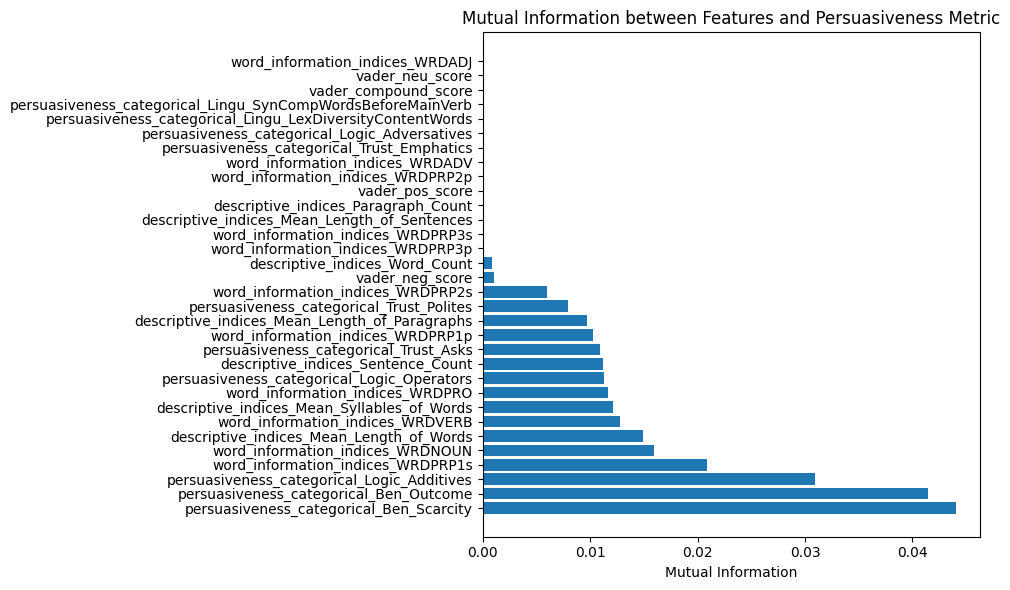

In [28]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Assuming you have your dataframe ready
X = df_num.drop('persuasiveness_metric', axis=1)
y = df_num['persuasiveness_metric']

# Calculate mutual information
mi = mutual_info_regression(X, y, discrete_features=False)

# Create a series for easier manipulation
mi_series = pd.Series(mi, index=X.columns)

# Normalize the mutual information values
mi_series_normalized = mi_series / mi_series.sum()

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi,
    'Normalized_MI': mi_series_normalized
})

# Sort by mutual information (descending order)
mi_df = mi_df.sort_values('Mutual_Information', ascending=False)

# Print the results
print("Mutual Information between features and persuasiveness_metric:")
print("=" * 60)
for idx, row in mi_df.iterrows():
    print(f"{row['Feature']:<30}: {row['Mutual_Information']:.6f}")

# Alternative: Print as a formatted table
print("\n" + "=" * 60)
print(f"{'Feature':<30} {'Mutual Information'}")
print("-" * 60)
for idx, row in mi_df.iterrows():
    print(f"{row['Feature']:<30} {row['Mutual_Information']:.6f}")

# You can also print the top N most informative features
print(f"\nTop 5 most informative features:")
print(mi_df.head())

# Or create a simple bar plot if you have matplotlib
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.barh(mi_df['Feature'], mi_df['Mutual_Information'])
    plt.xlabel('Mutual Information')
    plt.title('Mutual Information between Features and Persuasiveness Metric')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\nNote: Install matplotlib for visualization: pip install matplotlib")

### Categorical

In [29]:
# Create a DataFrame with non-numeric (categorical) columns
non_numeric = df2.select_dtypes(exclude=np.number)
non_numeric.drop(columns=['argument'], inplace=True)

# Add the target column to the categorical DataFrame (if not already included)
cat = non_numeric.copy()
if 'persuasiveness_metric' in df2.columns and 'persuasiveness_metric' not in cat.columns:
    cat['persuasiveness_metric'] = df2['persuasiveness_metric']

# Show the resulting categorical DataFrame
print(cat.head())

       monger_standard     monger_flesch  persuasiveness_metric
0    8th and 9th grade  Fairly difficult                      0
1  12th and 13th grade         Difficult                      0
2  11th and 12th grade         Difficult                      2
3  12th and 13th grade    Very confusing                      3
4  15th and 16th grade    Very confusing                      0


In [31]:
import pandas as pd
from sklearn.feature_selection import f_classif

# 1. Convert categorical features to dummy/one-hot encoded form
X_cat = pd.get_dummies(cat.drop('persuasiveness_metric', axis=1), drop_first=True)

# 2. Set target variable (assuming it's categorical or class labels)
y = cat['persuasiveness_metric']

# 3. Compute ANOVA F-scores and p-values
f_scores, p_values = f_classif(X_cat, y)

# 4. Create DataFrame for better readability
anova_results = pd.DataFrame({
    'Feature': X_cat.columns,
    'F-score': f_scores,
    'p-value': p_values
}).sort_values(by='F-score', ascending=False)

# 5. Display results
print("ANOVA F-scores and p-values:")
print(anova_results)

# 6. Optional: Filter statistically significant features (e.g., p < 0.05)
significant = anova_results[anova_results['p-value'] < 0.05]
print("\nStatistically significant features (p < 0.05):")
print(significant)

ANOVA F-scores and p-values:
                                Feature   F-score   p-value
4   monger_standard_15th and 16th grade  2.701547  0.013052
2   monger_standard_13th and 14th grade  2.387675  0.026763
3   monger_standard_14th and 15th grade  2.288023  0.033455
6   monger_standard_17th and 18th grade  1.605343  0.142000
0   monger_standard_11th and 12th grade  1.481110  0.181016
12    monger_standard_7th and 8th grade  1.294120  0.256719
5   monger_standard_16th and 17th grade  1.207028  0.299818
7   monger_standard_18th and 19th grade  1.018062  0.411702
18               monger_flesch_Standard  1.015070  0.413674
1   monger_standard_12th and 13th grade  0.967555  0.445809
9   monger_standard_21st and 22nd grade  0.673994  0.670736
19         monger_flesch_Very confusing  0.663030  0.679625
13    monger_standard_8th and 9th grade  0.609395  0.722998
14   monger_standard_9th and 10th grade  0.526128  0.788798
16       monger_flesch_Fairly difficult  0.430806  0.858695
17         

## Ordinal Logistic Regression

Features shape: (1313, 32)
Target shape: (1313,)
Target distribution:
persuasiveness_metric
-2      2
-1     78
 0    824
 1    260
 2    106
 3     32
 4     11
Name: count, dtype: int64

Feature statistics after standardization:
Mean (should be ~0): -0.000000
Std (should be ~1): 0.937857

=== MORD Ordinal Logistic Regression Results ===
Accuracy: 0.6160

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        16
           0       0.63      0.96      0.76       165
           1       0.30      0.06      0.10        52
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         2

    accuracy                           0.62       263
   macro avg       0.15      0.17      0.14       263
weighted avg       0.45      0.62      0.50       263


Feature Coefficients:
                                              Featur

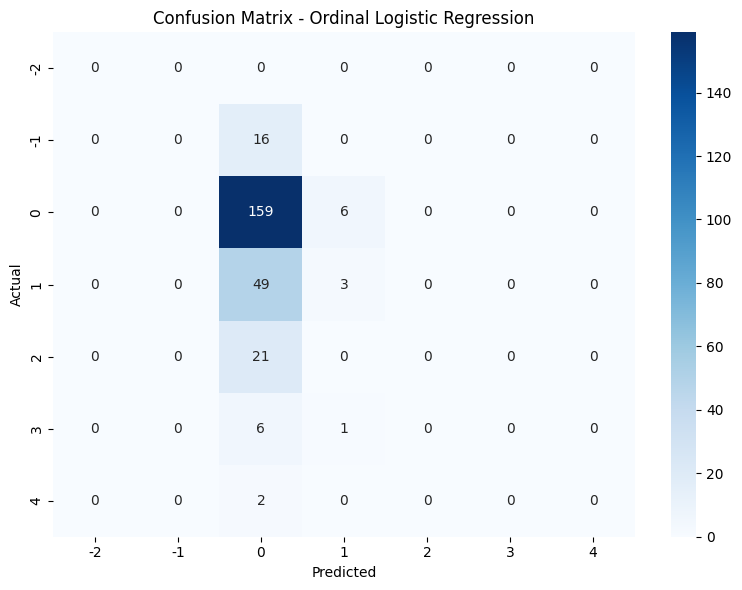


To use the trained model on new data:
predictions, probabilities = predict_new_data(new_df, scaler, model)


In [36]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Separate features and target
X = df_num.drop('persuasiveness_metric', axis=1)
y = df_num['persuasiveness_metric']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

# Standardize features using z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to keep column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\nFeature statistics after standardization:")
print(f"Mean (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"Std (should be ~1): {X_scaled_df.std().mean():.6f}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

# Using mord library for ordinal logistic regression
try:
    from mord import LogisticAT
    
    # Fit ordinal logistic regression
    model = LogisticAT(alpha=1.0)  # alpha is regularization parameter
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    print(f"\n=== MORD Ordinal Logistic Regression Results ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance (coefficients)
    print(f"\nFeature Coefficients:")
    # Handle different shapes of coefficients
    if hasattr(model, 'coef_'):
        coef_values = model.coef_.flatten() if model.coef_.ndim > 1 else model.coef_
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': coef_values
        }).sort_values('Coefficient', key=abs, ascending=False)
        print(feature_importance)
    else:
        print("Coefficients not available for this model.")
    
    # Get sorted unique class labels from the true labels
    class_labels = sorted(y.unique())
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix - Ordinal Logistic Regression')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # # Optional: Save the scaler and model for future use
    # import joblib
    # joblib.dump(scaler, 'feature_scaler.pkl')
    # joblib.dump(model, 'ordinal_logistic_model.pkl')
    # print(f"\nScaler and model saved to files.")
    
    # Function to make predictions on new data
    def predict_new_data(new_data, scaler, model):
        """
        Function to make predictions on new data
        
        Parameters:
        new_data: DataFrame with same columns as training features
        scaler: fitted StandardScaler
        model: fitted model
        
        Returns:
        predictions and probabilities
        """
        # Scale the new data
        new_data_scaled = scaler.transform(new_data)
        
        # Make predictions
        predictions = model.predict(new_data_scaled)
        probabilities = model.predict_proba(new_data_scaled)
        
        return predictions, probabilities
    
    print(f"\nTo use the trained model on new data:")
    print(f"predictions, probabilities = predict_new_data(new_df, scaler, model)")
    
except ImportError:
    print("Error: mord library not installed.")
    print("Please install with: pip install mord")
    print("This library is required for proper ordinal logistic regression.")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("Please check your data format and ensure 'persuasiveness_metric' column exists.")